#Set up & Load data

In [ ]:
!pip install numpy
!pip install opencv-python
!pip install tqdm
!pip install mediapipe

     |████████████████████████████████| 32.7 MB 154 kB/s 


In [ ]:
import csv
import cv2
import numpy as np
import os
import sys
import tqdm
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import requests
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow #Only in Colab
from google.colab import files

from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!zip -r 'Data.zip' '/content/drive/MyDrive/ML/FinalProject/Data'

  adding: content/drive/MyDrive/ML/FinalProject/Data/ (stored 0%)
  adding: content/drive/MyDrive/ML/FinalProject/Data/Right pose/ (stored 0%)
  adding: content/drive/MyDrive/ML/FinalProject/Data/Right pose/0.png (deflated 0%)
  adding: content/drive/MyDrive/ML/FinalProject/Data/Right pose/1.png (deflated 0%)
  adding: content/drive/MyDrive/ML/FinalProject/Data/Right pose/3.png (deflated 1%)
  adding: content/drive/MyDrive/ML/FinalProject/Data/Right pose/2.png (deflated 0%)
  adding: content/drive/MyDrive/ML/FinalProject/Data/Right pose/4.png (deflated 0%)
  adding: content/drive/MyDrive/ML/FinalProject/Data/Right pose/5.png (deflated 0%)
  adding: content/drive/MyDrive/ML/FinalProject/Data/Right pose/6.png (deflated 0%)
  adding: content/drive/MyDrive/ML/FinalProject/Data/Right pose/7.png (deflated 1%)
  adding: content/drive/MyDrive/ML/FinalProject/Data/Right pose/8.png (deflated 1%)
  adding: content/drive/MyDrive/ML/FinalProject/Data/Right pose/9.png (deflated 1%)
  adding: content

In [ ]:
!unzip -q /content/Data.zip -d ./Data

# Extract landmarks by Mediapipe Pose

In [ ]:
images_in_folder = '/content/Data/content/drive/MyDrive/ML/FinalProject/Data'
images_out_folder = 'images_out_basic'
csv_out_path = 'csv_out.csv'

In [ ]:
keypoints = ['nose',
        'left_eye_inner', 'left_eye', 'left_eye_outer',
        'right_eye_inner', 'right_eye', 'right_eye_outer',
        'left_ear', 'right_ear',
        'mouth_left', 'mouth_right',
        'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index']
dimension = ['x', 'y', 'z']

In [ ]:
from numpy.core.multiarray import concatenate
variable = []
for i in keypoints:
  for j in dimension:
    variable.append(i+j)
full_variable = ['image_name', 'pose_class_name']
full_variable.extend(variable)

In [ ]:
with open(csv_out_path, 'w') as csv_out_file:
  csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
  csv_out_writer.writerow(i for i in full_variable) 
  # Folder names are used as pose class names.
  pose_class_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])

  for pose_class_name in pose_class_names:
    print('Bootstrapping ', pose_class_name, file=sys.stderr)

    if not os.path.exists(os.path.join(images_out_folder, pose_class_name)):
      os.makedirs(os.path.join(images_out_folder, pose_class_name))

    image_names = sorted([
        n for n in os.listdir(os.path.join(images_in_folder, pose_class_name))
        if not n.startswith('.')])
    for image_name in tqdm.tqdm(image_names, position=0):
      # Load image.
      input_frame = cv2.imread(os.path.join(images_in_folder, pose_class_name, image_name))
      input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

      # Initialize fresh pose tracker and run it.
      with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose_tracker:
        result = pose_tracker.process(image=input_frame)
        pose_landmarks = result.pose_landmarks
      
      # Save image with pose prediction (if pose was detected).
      output_frame = input_frame.copy()
      if pose_landmarks is not None:
        mp_drawing.draw_landmarks(
            image=output_frame,
            landmark_list=pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS)
      output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)
      cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
      
      # Save landmarks.
      if pose_landmarks is not None:
        # Check the number of landmarks and take pose landmarks.
        assert len(pose_landmarks.landmark) == 33, 'Unexpected number of predicted pose landmarks: {}'.format(len(pose_landmarks.landmark))
        pose_landmarks = [[lmk.x, lmk.y, lmk.z] for lmk in pose_landmarks.landmark]

        # Map pose landmarks from [0, 1] range to absolute coordinates to get
        # correct aspect ratio.
        frame_height, frame_width = output_frame.shape[:2]
        pose_landmarks *= np.array([frame_width, frame_height, frame_width])

        # Write pose sample to CSV.
        pose_landmarks = np.around(pose_landmarks, 5).flatten().astype(np.str).tolist()
        csv_out_writer.writerow([image_name, pose_class_name] + pose_landmarks)

Bootstrapping  No sitting pose
100%|██████████| 117/117 [00:32<00:00,  3.63it/s]
Bootstrapping  Right pose
100%|██████████| 586/586 [02:04<00:00,  4.72it/s]
Bootstrapping  Wrong pose
100%|██████████| 612/612 [02:05<00:00,  4.88it/s]


In [ ]:
files.download(csv_out_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [ ]:
sitting_pose = pd.read_csv('/content/csv_out.csv')

# Data manipulation
#sitting_pose = sitting_pose[['pose_class_name','nosex','nosey', 'nosez', 'left_eyex', 'left_eyey', 'left_eyez', 'right_eyex', 'right_eyey', 'right_eyez','left_earx', 'left_eary','left_earz','right_earx','right_eary','right_earz','mouth_leftx','mouth_lefty','mouth_leftz','mouth_rightx', 'mouth_righty','mouth_rightz','left_shoulderx', 'left_shouldery', 'left_shoulderz', 'right_shoulderx', 'right_shouldery', 'right_shoulderz', 'left_elbowx', 'left_elbowy', 'left_elbowz', 'right_elbowx', 'right_elbowy', 'right_elbowz', 'left_wristx', 'left_wristy', 'left_wristz', 'right_wristx', 'right_wristy', 'right_wristz', 'left_hipx', 'left_hipy', 'left_hipz', 'right_hipx', 'right_hipy', 'right_hipz' ]]

X = sitting_pose.iloc[:,2:]
y = sitting_pose['pose_class_name']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)

In [ ]:
X_test

,nosex,nosey,nosez,left_eye_innerx,left_eye_innery,left_eye_innerz,left_eyex,left_eyey,left_eyez,left_eye_outerx,left_eye_outery,left_eye_outerz,right_eye_innerx,right_eye_innery,right_eye_innerz,right_eyex,right_eyey,right_eyez,right_eye_outerx,right_eye_outery,right_eye_outerz,left_earx,left_eary,left_earz,right_earx,right_eary,right_earz,mouth_leftx,mouth_lefty,mouth_leftz,mouth_rightx,mouth_righty,mouth_rightz,left_shoulderx,left_shouldery,left_shoulderz,right_shoulderx,right_shouldery,right_shoulderz,left_elbowx,...,left_index_1z,right_index_1x,right_index_1y,right_index_1z,left_thumb_2x,left_thumb_2y,left_thumb_2z,right_thumb_2x,right_thumb_2y,right_thumb_2z,left_hipx,left_hipy,left_hipz,right_hipx,right_hipy,right_hipz,left_kneex,left_kneey,left_kneez,right_kneex,right_kneey,right_kneez,left_anklex,left_ankley,left_anklez,right_anklex,right_ankley,right_anklez,left_heelx,left_heely,left_heelz,right_heelx,right_heely,right_heelz,left_foot_indexx,left_foot_indexy,left_foot_indexz,right_foot_indexx,right_foot_indexy,right_foot_indexz
884,292.41724,66.34082,11.06966,295.65458,55.97179,13.55990,295.79551,55.71148,13.47289,295.75298,55.42628,13.36581,292.26294,54.44853,-10.79573,289.76773,53.09573,-10.82518,286.65002,51.47122,-10.82648,282.69483,49.42420,34.47271,272.45774,45.26640,-74.72698,285.95206,72.38059,21.87728,281.42067,70.68152,-9.65675,232.03382,72.26124,82.74225,259.23739,80.20223,-127.77295,237.70719,...,111.17290,348.56534,119.32278,-82.89565,299.10471,140.50199,114.81269,340.81525,121.87468,-82.84846,163.04437,207.81195,73.45885,174.54918,224.04240,-73.53868,251.39289,216.16359,189.37896,283.30616,251.46493,-33.08847,206.84889,259.84897,239.05319,209.65575,297.84642,64.07321,191.01487,261.75815,243.46102,183.57515,296.51119,79.18759,219.29101,286.99306,278.18891,227.02666,336.05354,137.32920
912,129.88754,89.64147,-141.52507,129.00021,79.19391,-126.26188,130.39251,78.66041,-126.37343,131.52788,78.12922,-126.53477,121.07228,79.62920,-143.28081,116.17003,79.54559,-143.31860,110.71925,79.56791,-143.32811,120.37816,80.80721,-39.18436,94.82175,84.19265,-115.30613,129.91655,99.50089,-105.84282,121.50573,100.86276,-127.62957,113.26225,135.99662,73.00476,96.15054,139.62609,-149.97192,154.17131,...,22.47288,278.48142,188.49842,-170.88966,223.19528,186.39825,45.39647,270.75713,190.30030,-150.88222,172.12002,269.46374,69.92540,159.67391,269.05642,-69.79466,241.38607,293.73819,134.57967,273.17782,310.21064,-60.59729,263.81910,372.20481,221.80405,265.20402,406.30265,23.02797,259.46179,387.75215,229.30522,247.82088,420.42635,33.57555,301.51235,389.18014,239.89838,310.46329,436.03018,40.54946
823,70.91701,28.20296,-490.93266,68.69238,14.17227,-461.87832,71.37101,13.90196,-461.97591,73.75889,13.70205,-462.14212,56.70627,15.29501,-487.08268,50.17187,16.00719,-487.20589,42.89048,17.13162,-487.25854,65.97210,19.57263,-305.00401,24.71896,27.36877,-416.15271,74.98914,42.66328,-429.17400,60.31497,44.26398,-461.25047,85.34214,81.14734,-125.00246,15.28486,111.04616,-431.04949,119.54765,...,-278.04879,186.42807,225.60322,-561.69770,211.58419,184.31456,-230.79095,178.97639,224.74659,-511.81453,69.43764,233.75687,86.36924,16.35862,261.14575,-86.29009,153.32227,190.33009,-55.20696,73.19414,268.58743,-363.16707,140.89485,261.57203,109.50063,116.36657,268.32366,-51.41125,129.31681,277.77690,123.77234,109.26162,261.82532,-15.80185,176.26070,272.02498,75.93044,161.52005,280.67195,-37.20426
124,250.13775,33.26268,-12.61103,251.59196,25.42077,-6.30166,251.12914,24.94755,-6.36795,250.56881,24.39905,-6.44051,250.72552,24.59471,-27.45477,249.77533,23.60670,-27.44880,248.71129,22.48324,-27.43148,240.36747,19.56982,27.19324,239.36050,18.06986,-68.10153,243.53655,37.13457,1.83519,242.23081,36.14910,-25.68906,206.40538,46.84292,76.84240,212.26318,48.64761,-107.54888,217.56005,...,58.66579,296.66723,108.43029,-80.12372,271.18614,114.95782,68.97032,291.12373,108.57497,-71.82390,198.55709,150.94848,54.84866,207.22554,161.15070,-54.63544,270.27674,169.799

In [ ]:
len(sitting_pose)

1262

In [ ]:
len(X_train)

1009

## Train with KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pipe = Pipeline([('scaler',MinMaxScaler())]) 
estimator = KNeighborsClassifier(n_neighbors=5)
final_pipe_knn = Pipeline(steps=[
                       ('preprocessor', pipe),
                       ('model',estimator)
                       ])

In [ ]:
final_pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', Pipeline(steps=[('scaler', MinMaxScaler())])),
                ('model', KNeighborsClassifier())])

In [ ]:
y_train_pred = final_pipe_knn.predict(X_train)
y_test_pred = final_pipe_knn.predict(X_test)
y_test_pred_proba = final_pipe_knn.predict_proba(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
# Acc on train set
print(accuracy_score(y_train,y_train_pred))

# Acc on test set
print(accuracy_score(y_test,y_test_pred))

0.9871159563924677
0.9486166007905138


## Train with SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
pipe = Pipeline([('scaler',MinMaxScaler())]) 
estimator = SVC()
final_pipe_svm = Pipeline(steps=[
                       ('preprocessor', pipe),
                       ('model',estimator)
                       ])

In [ ]:
final_pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', Pipeline(steps=[('scaler', MinMaxScaler())])),
                ('model', SVC())])

In [ ]:
y_train_pred = final_pipe_svm.predict(X_train)
y_test_pred = final_pipe_svm.predict(X_test)
#y_test_pred_proba = final_pipe.predict_proba(X_test)

In [ ]:

# Acc on train set
print(accuracy_score(y_train,y_train_pred))

# Acc on test set
print(accuracy_score(y_test,y_test_pred))

0.9672943508424182
0.9367588932806324


## Train with Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree = DecisionTreeClassifier()


In [ ]:
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
y_test_pred_proba = tree.predict_proba(X_test)

In [ ]:

# Acc on train set
print(accuracy_score(y_train,y_train_pred))

# Acc on test set
print(accuracy_score(y_test,y_test_pred))

1.0
0.9407114624505929


## Train with Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
rf = RandomForestClassifier()


In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
y_test_pred_proba = rf.predict_proba(X_test)

In [ ]:

# Acc on train set
print(accuracy_score(y_train,y_train_pred))

# Acc on test set
print(accuracy_score(y_test,y_test_pred))

1.0
0.9841897233201581


## RF fine tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
params = {#'n_estimators': randint(low=20, high=100), 
          'max_features': randint(low=30, high=90),
          'max_depth': randint(low=30, high=100),
          'min_samples_leaf': randint(low=1, high=10)
          }

In [ ]:
rnd_search = RandomizedSearchCV(rf, param_distributions=params,
                                n_iter=20, cv=5, scoring='accuracy', random_state=19)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f28ca50c810>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f28ca50c790>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f28ca50c9d0>},
                   random_state=19, scoring='accuracy')

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.9682675730259593 {'max_depth': 70, 'max_features': 49, 'min_samples_leaf': 5}
0.9593517560711294 {'max_depth': 61, 'max_features': 32, 'min_samples_leaf': 9}
0.9632973745135708 {'max_depth': 52, 'max_features': 64, 'min_samples_leaf': 6}
0.974213092951086 {'max_depth': 40, 'max_features': 52, 'min_samples_leaf': 3}
0.9613221023594896 {'max_depth': 69, 'max_features': 45, 'min_samples_leaf': 8}
0.9682675730259593 {'max_depth': 69, 'max_features': 37, 'min_samples_leaf': 5}
0.9692527461701393 {'max_depth': 96, 'max_features': 83, 'min_samples_leaf': 4}
0.9613171764937688 {'max_depth': 87, 'max_features': 85, 'min_samples_leaf': 9}
0.9652874242648146 {'max_depth': 90, 'max_features': 67, 'min_samples_leaf': 6}
0.9623122013693907 {'max_depth': 62, 'max_features': 79, 'min_samples_leaf': 5}
0.973227919806906 {'max_depth': 84, 'max_features': 58, 'min_samples_leaf': 2}
0.9742081670853653 {'max_depth': 42, 'max_features': 49, 'min_samples_leaf': 2}
0.9742081670853653 {'max_depth': 75, 'max_

In [ ]:
params = {#'n_estimators': randint(low=20, high=60), 
          'max_features': list(range(40,60)),
          'max_depth': list(range(70,90)),
          #'min_samples_leaf': randint(low=1, high=10)
          }

In [ ]:
 clf = GridSearchCV(estimator = rf, 
                   param_grid = params,
                   scoring='accuracy',
                   n_jobs=-1,
                   cv = 5)

In [ ]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
                                       80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
                         'max_features': [40, 41, 42, 43, 44, 45, 46, 47, 48,
                                          49, 50, 51, 52, 53, 54, 55, 56, 57,
                                          58, 59]},
             scoring='accuracy')

In [ ]:
cv_result_df = pd.DataFrame(clf.cv_results_)
cv_result_df = cv_result_df.sort_values('rank_test_score')
for rec in cv_result_df[['params','mean_test_score','std_test_score','rank_test_score']].values[:5]:
    print(f'Rank {rec[-1]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score:{rec[1]:.5f} +- {rec[2]:.5f}')
    print('-'*10)

Rank 1
Params: {'max_depth': 78, 'max_features': 46}
Mean score:0.98115 +- 0.00858
----------
Rank 2
Params: {'max_depth': 88, 'max_features': 52}
Mean score:0.98017 +- 0.00631
----------
Rank 2
Params: {'max_depth': 79, 'max_features': 48}
Mean score:0.98017 +- 0.00704
----------
Rank 4
Params: {'max_depth': 80, 'max_features': 53}
Mean score:0.98016 +- 0.00835
----------
Rank 4
Params: {'max_depth': 85, 'max_features': 40}
Mean score:0.98016 +- 0.00835
----------


In [ ]:
clf.best_score_

0.981153637751835

In [ ]:
#Get back the best_estimator
best_estimator = clf.best_estimator_
best_estimator.fit(X_train,y_train)

RandomForestClassifier(max_depth=78, max_features=46)

In [ ]:
y_train_pred = best_estimator.predict(X_train)
print(accuracy_score(y_train,y_train_pred))

1.0


In [ ]:
y_test_pred = best_estimator.predict(X_test)
print(accuracy_score(y_test,y_test_pred))

0.9723320158102767


##XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb

In [ ]:
 xgboost = XGBClassifier()


In [ ]:
xgboost.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [ ]:
y_train_pred_xgb = xgboost.predict(X_train)
y_test_pred_xgb = xgboost.predict(X_test)
y_test_pred_proba_xgb = xgboost.predict_proba(X_test)

In [ ]:

# Acc on train set
print(accuracy_score(y_train,y_train_pred_xgb))

# Acc on test set
print(accuracy_score(y_test,y_test_pred_xgb))

1.0
0.9723320158102767


# Error Analysis

In [ ]:
X = X_test.reset_index()[['index']]
label = y_test.reset_index()
label.drop(columns = 'index', inplace = True)
predict_proba = pd.DataFrame(y_test_pred_proba)
predict_proba.columns = ['No sitting', 'Right', 'Wrong']
predict = pd.DataFrame(y_test_pred)
predict.columns = ['Predict']

In [ ]:
ea1 = pd.merge(predict, predict_proba, how='inner', left_index=True, right_index=True)
ea2 = pd.merge(ea1, X, how='inner', left_index=True, right_index=True)
ea = pd.merge(ea2, label, how='inner', left_index=True, right_index=True)
ea

,Predict,No sitting,Right,Wrong,index,pose_class_name
0,Wrong pose,0.00,0.01,0.99,884,Wrong pose
1,Wrong pose,0.00,0.02,0.98,912,Wrong pose
2,Wrong pose,0.00,0.10,0.90,823,Wrong pose
3,Right pose,0.00,0.85,0.15,124,Right pose
4,Right pose,0.00,1.00,0.00,186,Right pose
...,...,...,...,...,...,...
248,Right pose,0.00,0.96,0.04,219,Right pose
249,Wrong pose,0.00,0.00,1.00,1145,Wrong pose
250,Right pose,0.00,0.84,0.16,287,Right pose
251,No sitting pose,0.98,0.01,0.01,6,No sitting pose


In [ ]:
img = sitting_pose['image_name']

In [ ]:
wrong_predict = ea[ea['Predict']!=ea['pose_class_name']]
wrong_predict_img = pd.merge(wrong_predict, img, how='left', left_on='index', right_index=True)

In [ ]:
len(wrong_predict)

7

In [ ]:
wrong_predict_img= wrong_predict_img.reset_index()

In [ ]:
wrong_predict_img

,level_0,Predict,No sitting,Right,Wrong,index,pose_class_name,image_name
0,8,Right pose,0.0,0.46,0.54,756,Wrong pose,121 (1).png
1,133,Wrong pose,0.0,0.52,0.48,403,Right pose,435.png
2,169,Right pose,0.0,0.78,0.22,864,Wrong pose,350.png
3,189,Right pose,0.0,0.31,0.69,866,Wrong pose,353.png
4,204,Right pose,0.0,0.62,0.38,1256,Wrong pose,890.png
5,217,Right pose,0.0,0.56,0.44,1043,Wrong pose,503 (1).png
6,229,Right pose,0.0,0.46,0.54,1059,Wrong pose,511 (1).png


In [ ]:
data = []
for i in range(len(wrong_predict_img)):
  link = os.path.join(images_in_folder, wrong_predict_img.iloc[i,6], wrong_predict_img.iloc[i,7])
  data.append(link)

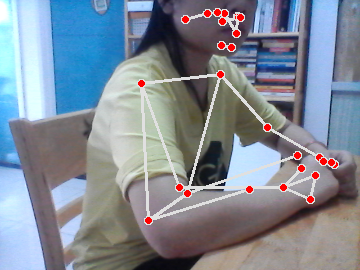

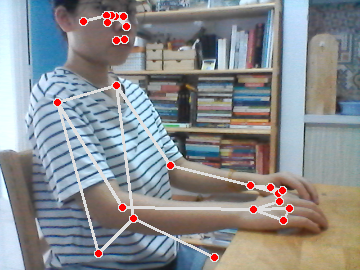

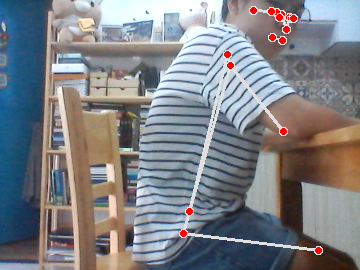

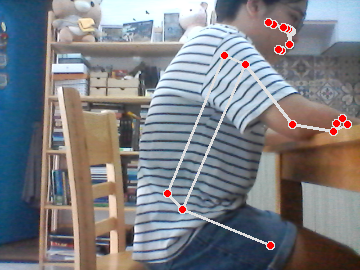

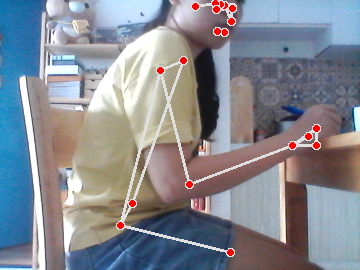

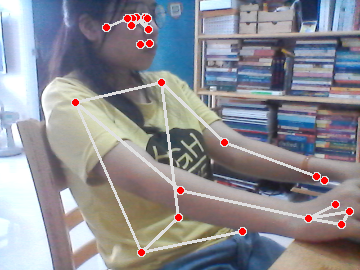

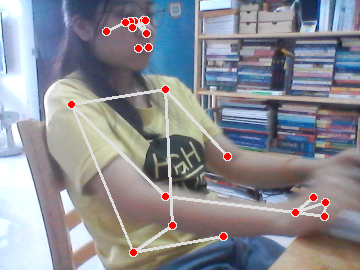

In [ ]:
with mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5) as pose:
  for frame in data:
    image = cv2.imread(frame)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    annotated_image = image.copy()
    mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    cv2_imshow(annotated_image)

## Save model

In [ ]:
import pickle
pickle.dump(rf, open('rf_model_2712.pkl', 'wb'))